In [3]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, resample_apply
import talib as ta
import matplotlib.pyplot as plt
import yfinance as yf 
import datetime
import seaborn as sns
import pandas as pd 
import numpy as np

/usr/local/lib/python3.8/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [1]:
!pip install backtesting 
!pip install yfinance 
!pip install ta-lib-binary 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173819 sha256=a76fa037846eaf72e675c631cd0c9976b521e79f9b53daf514701e80796cdcd1
  Stored in directory: /root/.cache/pip/wheels/cd/5c/f7/aafe95c37f8b07f838fb0a8cb3177de23a38c09cbd10b447b8
Successfully built backtesting
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 54

In [104]:
# ticker and the start and end dates for testing
ticker =  input("Enter ticker: ")
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2023, 1, 1)

Enter ticker: ^GDAXI


In [105]:
df=yf.download( ticker , start=start,end=end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,7689.459961,7789.939941,7689.459961,7778.779785,7778.779785,140345500
2013-01-03,7762.129883,7777.020020,7737.979980,7756.439941,7756.439941,86174100
2013-01-04,7740.990234,7779.669922,7727.549805,7776.370117,7776.370117,101577000
2013-01-07,7760.009766,7767.549805,7713.419922,7732.660156,7732.660156,151695400
2013-01-08,7710.700195,7754.379883,7683.479980,7695.830078,7695.830078,130425500
...,...,...,...,...,...,...
2022-12-23,13945.589844,14000.679688,13874.500000,13940.929688,13940.929688,28738700
2022-12-27,14047.419922,14063.139648,13966.349609,13995.099609,13995.099609,22975000
2022-12-28,14013.719727,14018.469727,13914.620117,13925.599609,13925.599609,27583800


In [106]:
def SMA(array, n):
    """Simple moving average"""
    return pd.Series(array).rolling(n).mean()

def RSI(array, n):
    """Relative strength index"""
    # Approximate; good enough
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

In [107]:
class System(Strategy):
    d_rsi = 30  # Daily RSI lookback periods
    w_rsi = 30  # Weekly
    level = 70
    
    def init(self):
        # Compute moving averages the strategy demands
        self.ma10 = self.I(SMA, self.data.Close, 10)
        self.ma20 = self.I(SMA, self.data.Close, 20)
        self.ma50 = self.I(SMA, self.data.Close, 50)
        self.ma100 = self.I(SMA, self.data.Close, 100)
        
        # Compute daily RSI(30)
        self.daily_rsi = self.I(RSI, self.data.Close, self.d_rsi)
        
        # To construct weekly RSI, we can use `resample_apply()`
        # helper function from the library
        self.weekly_rsi = resample_apply(
            'W-FRI', RSI, self.data.Close, self.w_rsi)
        
        
    def next(self):
        price = self.data.Close[-1]
        
        # If we don't already have a position, and
        # if all conditions are satisfied, enter long.
        if (not self.position and
            self.daily_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.level and
            self.weekly_rsi[-1] > self.daily_rsi[-1] and
            self.ma10[-1] > self.ma20[-1] > self.ma50[-1] > self.ma100[-1] and
            price > self.ma10[-1]):

            self.buy()

        elif price < self.ma10[-1]:
            self.position.close()

In [108]:
bt = Backtest(df, System, commission=.001, cash=100_000)
stats= bt.run()

In [109]:
%%time

stats=bt.optimize(d_rsi=range(10, 35, 5),
                  w_rsi=range(10, 35, 5),
                  level=range(30, 80, 10),
                  maximize='Return [%]')
stats

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 260 ms, sys: 57.8 ms, total: 318 ms
Wall time: 13.6 s


Start                     2013-01-02 00:00:00
End                       2022-12-30 00:00:00
Duration                   3649 days 00:00:00
Exposure Time [%]                   12.480253
Equity Final [$]                106783.099508
Equity Peak [$]                 122322.340687
Return [%]                             6.7831
Buy & Hold Return [%]               78.994524
Return (Ann.) [%]                    0.655322
Volatility (Ann.) [%]                3.763064
Sharpe Ratio                         0.174146
Sortino Ratio                        0.250842
Calmar Ratio                         0.048294
Max. Drawdown [%]                  -13.569533
Avg. Drawdown [%]                    -1.43211
Max. Drawdown Duration     2846 days 00:00:00
Avg. Drawdown Duration      168 days 00:00:00
# Trades                                   39
Win Rate [%]                        33.333333
Best Trade [%]                        7.05075
Worst Trade [%]                     -2.317722
Avg. Trade [%]                    

In [110]:
print(stats._strategy)

System(d_rsi=15,w_rsi=10,level=60)


In [111]:
bt.plot()

Row(id='9200', ...)

In [112]:
#These are the trades that would executed with this strategy.
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,11,186,191,8653.885475,8618.589844,-388.251939,-0.004079,2013-09-24,2013-10-01,7 days
1,11,198,236,8713.735304,9246.889648,5864.697792,0.061186,2013-10-11,2013-12-04,54 days
2,10,252,258,9607.848250,9473.870117,-1339.781328,-0.013945,2014-01-02,2014-01-10,8 days
3,11,260,268,9400.851421,9646.650391,2703.788667,0.026146,2014-01-14,2014-01-24,10 days
4,11,286,293,9651.091646,9592.900391,-640.103804,-0.006029,2014-02-19,2014-02-28,9 days
5,10,358,364,9913.724133,9950.519531,367.953984,0.003712,2014-06-04,2014-06-12,8 days
6,10,371,372,10001.391791,9938.639648,-627.521426,-0.006274,2014-06-23,2014-06-24,1 days
7,10,515,531,10241.811658,10675.589844,4337.781855,0.042354,2015-01-19,2015-02-10,22 days
8,10,534,563,10963.342038,11736.339844,7729.978057,0.070507,2015-02-13,2015-03-26,41 days
9,9,566,577,12066.254396,11942.360352,-1115.046396,-0.010268,2015-03-31,2015-04-17,17 days


In [ ]:
class RsiOscillator(Strategy):

    upper_bound = 70 
    lower_bound = 30 
    rsi_window=14
    def init(self):
      self.rsi=self.I(ta.RSI, self.data.Close,self.rsi_window)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.sell()
        elif crossover(self.lower_bound, self.rsi):
            self.buy()

/usr/local/lib/python3.8/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 360 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

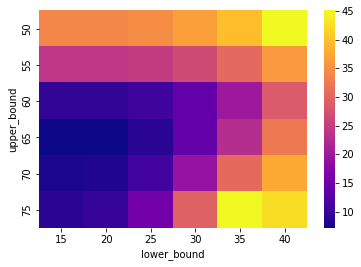

Start                     2013-01-02 00:00:00
End                       2022-12-30 00:00:00
Duration                   3649 days 00:00:00
Exposure Time [%]                   73.550437
Equity Final [$]                 27078.408711
Equity Peak [$]                  38867.044794
Return [%]                         170.784087
Buy & Hold Return [%]              317.443826
Return (Ann.) [%]                    10.48331
Volatility (Ann.) [%]               23.156372
Sharpe Ratio                         0.452718
Sortino Ratio                        0.738072
Calmar Ratio                         0.265512
Max. Drawdown [%]                  -39.483315
Avg. Drawdown [%]                   -3.011731
Max. Drawdown Duration      924 days 00:00:00
Avg. Drawdown Duration       26 days 00:00:00
# Trades                                    8
Win Rate [%]                             62.5
Best Trade [%]                      67.826015
Worst Trade [%]                    -17.071059
Avg. Trade [%]                    

Row(id='4646', ...)

In [ ]:
bt = Backtest(df, RsiOscillator, commission=.002,
              exclusive_orders=True)
stats,heatmap = bt.optimize(
        upper_bound = range(50,80,5),
        lower_bound = range(15,45,5),
        rsi_window = range(10,30,2),
        maximize='Win Rate [%]',
        return_heatmap=True)
hm = heatmap.groupby(["upper_bound","lower_bound"]).mean().unstack()
sns.heatmap(hm, cmap="plasma")
plt.show()

print(stats)
bt.plot()

In [ ]:
print(stats['_trades'].to_string())

   Size  EntryBar  ExitBar  EntryPrice   ExitPrice          PnL  ReturnPct  EntryTime   ExitTime Duration
0   252       666     1101   39.548941   55.689999  4067.546466   0.408129 2015-08-25 2017-05-17 631 days
1  -253      1101     1222   55.578619   63.700001 -2054.709680  -0.146124 2017-05-17 2017-11-07 174 days
2  -188      1222     1456   63.572601   70.570000 -1315.510999  -0.110069 2017-11-07 2018-10-12 339 days
3   151      1456     1505   70.711140   58.639999 -1822.742186  -0.170711 2018-10-12 2018-12-24  73 days
4   151      1505     1777   58.757279   98.610001  6017.760905   0.678260 2018-12-24 2020-01-24 396 days
5  -151      1777     1811   98.412781   80.089996  2766.740425   0.186183 2020-01-24 2020-03-13  49 days
6   220      1811     2455   80.250176  119.720001  8683.361476   0.491835 2020-03-13 2022-10-03 934 days
7   219      2455     2517  119.959441  123.320000   735.962305   0.028014 2022-10-03 2022-12-30  88 days
